In [1]:
# On met ici toutes les bibliothèques utilisées pendant le projet
# Si nécessaire, installer les modules manquants en fonction des erreurs
# que cette node peut produire (par exemple, tensorflow, pytorch et librosa)

import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import s3fs
import sys
import tensorflow as tf
import torch
import zipfile
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

2024-04-25 10:56:28.201982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 10:56:29.110616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [6]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")


['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [7]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [8]:
# Download the data
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

[None]

In [9]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

In [2]:
# Chargement des jeux de données de RIR
deconvolved_human1 = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
deconvolved_human2 = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
deconvolved_empty = np.load('data/LivingRoom_preprocessed_hack/Empty/deconvolved.npy')

In [22]:
# Calculer les niveaux RMS pour chaque datapoint de chaque micro
niveaux_rms_human1 = []
niveaux_rms_human2 = []
for i in range (4):
    niveaux_rms_h1_i = np.sqrt(np.mean(deconvolved_human1[:,i,:]**2, axis=(1)))
    niveaux_rms_h2_i = np.sqrt(np.mean(deconvolved_human2[:,i,:]**2, axis=(1)))
    niveaux_rms_human1.append(niveaux_rms_h1_i)
    niveaux_rms_human2.append(niveaux_rms_h2_i)

niveaux_rms_human1 = np.array(niveaux_rms_human1)
niveaux_rms_human2 = np.array(niveaux_rms_human2)

# Vérifier les dimensions de niveaux_rms
print("Dimensions des données originales du 1er humain: ", deconvolved_human1.shape)
print("Dimensions de niveaux_rms du 1er humain:", niveaux_rms_human1.shape)
print("Dimensions des données originales du 2eme humain: ", deconvolved_human2.shape)
print("Dimensions de niveaux_rms du 2eme humain:", niveaux_rms_human2.shape)

Dimensions des données originales du 1er humain:  (1000, 4, 667200)
Dimensions de niveaux_rms du 1er humain: (4, 1000)
Dimensions des données originales du 2eme humain:  (104, 4, 667200)
Dimensions de niveaux_rms du 2eme humain: (4, 104)


In [3]:
# Chargement des jeux de données de positions
centroid_human1 = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')
centroid_human2 = np.load('data/LivingRoom_preprocessed_hack/Human2/centroid.npy')

In [13]:
# Vérification des shapes des données récupérées
print(centroid_human1.shape)
print(centroid_human2.shape)

(1000, 2)
(104, 2)


In [25]:
# Mise en commun de human1 et human2 en un seul jeu de donnée pour les RMS et les positions
niveaux_rms = np.concatenate((niveaux_rms_human1, niveaux_rms_human2), axis=1)

# on transpose les arrays avec .T pour éviter les conflits pendant la mise en commun,
# puis on retranspose derrière
positions = np.concatenate((centroid_human1.T, centroid_human2.T), axis=1)
positions = positions.T

#vérification des shapes de la mise en commun
print(niveaux_rms.shape)
print(positions.shape)

(4, 1104)
(1104, 2)


In [26]:
# Préparation des données pour l'entrainement

# X : données de niveaux RMS (4, N_datapoints)
# y : données de position (N_datapoints, 2)

# Diviser les données en ensembles d'entraînement et de test
# On transpose X pour avoir N_datapoints en premier pour les deux datasets
X_train, X_test, y_train, y_test = train_test_split(niveaux_rms.T, positions, test_size=0.2, random_state=42)

# Réduire les données à 3, 2 et 1 micro pour faire des comparaisons avec le nombre de micros
# Division des données au nombre de micros respectifs en ensembles d'entraînement et de test également
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(niveaux_rms[0:3,:].T, positions, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(niveaux_rms[0:2,:].T, positions, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(niveaux_rms[0:1,:].T, positions, test_size=0.2, random_state=42)

# Vérification que les données divisées aient bien la bonne shape pour s'entrainer et tester les modèles au nombre de micros voulus
# Rappel: Shape des données = (N_datapoints, N_micros)
print(X_train.shape)
print(X_train_3.shape)
print(X_train_2.shape)
print(X_train_1.shape)


(883, 4)
(883, 3)
(883, 2)
(883, 1)


## Algorithmes utilisés:
 - KNN 
 - Linear Regression
 - CNN classique
 - VGGish

KNN et la régression linéaire étant tous les deux utilisés dans le papier, ils seront comparés aux résultats du livre pour le nombre de microphones correspondants. CNN ne sera utilisé qu'avec 4 microphones, pas moins.

In [16]:
# Implémentation de KNN

# Choix des voisins: 4, car c'est celui qui minimise la distance moyenne pour les 4 micros
# On considère les 4 micros comme le "standard" pour l'entrainement et la création des modèles qui suivent

knn = KNeighborsRegressor(n_neighbors=4)
knn_3 = KNeighborsRegressor(n_neighbors=4)
knn_2 = KNeighborsRegressor(n_neighbors=4)
knn_1 = KNeighborsRegressor(n_neighbors=4)

# Entrainement du modèle knn pour 4 à 1 micro
knn.fit(X_train, y_train)
knn_3.fit(X_train_3, y_train_3)
knn_2.fit(X_train_2, y_train_2)
knn_1.fit(X_train_1, y_train_1)

# Prediction des positions pour chaque knn
predictions = knn.predict(X_test)
predictions_3 = knn_3.predict(X_test_3)
predictions_2 = knn_2.predict(X_test_2)
predictions_1 = knn_1.predict(X_test_1)

In [17]:
# Evaluation (moyenne de la distance des prédictions par rapport aux distances réelles)
# On divise par 10 car les résultats sont en milimètres (nous voulons des centimètres pour comparer avec le livre)
knn_eval = np.mean(np.abs(y_test - predictions)) /10
knn_eval_3 = np.mean(np.abs(y_test_3 - predictions_3)) /10
knn_eval_2 = np.mean(np.abs(y_test_2 - predictions_2)) /10
knn_eval_1 = np.mean(np.abs(y_test_1 - predictions_1)) /10

# Calcul de l'ecart-type, pour indiquer l'écart des prédictions par rapport à la moyenne
knn_std = np.std(np.abs(y_test - predictions)) /10
knn_std_3 = np.std(np.abs(y_test_3 - predictions_3)) /10
knn_std_2 = np.std(np.abs(y_test_2 - predictions_2)) /10
knn_std_1 = np.std(np.abs(y_test_1 - predictions_1)) /10

# Comparaison des résultats pour le nombre de micros pour les KNN
# Pour comparer les résultats au papier, on passe les données en cm
# On arrondit également à deux chiffres après la virgule
print("KNN distance moyenne par rapport à la position réelle pour 4 microphones:", np.round(knn_eval, 2), "cm, écart-type:", np.round(knn_std, 2), "cm")
print("KNN distance moyenne par rapport à la position réelle pour 3 microphones:", np.round(knn_eval_3, 2), "cm, écart-type:", np.round(knn_std_3, 2), "cm")
print("KNN distance moyenne par rapport à la position réelle pour 2 microphones:", np.round(knn_eval_2, 2), "cm, écart-type:", np.round(knn_std_2, 2), "cm")
print("KNN distance moyenne par rapport à la position réelle pour 1 microphone:", np.round(knn_eval_1, 2), "cm, écart-type:", np.round(knn_std_1, 2), "cm")

KNN distance moyenne par rapport à la position réelle pour 4 microphones: 62.4 cm, écart-type: 64.25 cm
KNN distance moyenne par rapport à la position réelle pour 3 microphones: 79.55 cm, écart-type: 71.57 cm
KNN distance moyenne par rapport à la position réelle pour 2 microphones: 93.68 cm, écart-type: 68.5 cm
KNN distance moyenne par rapport à la position réelle pour 1 microphone: 103.44 cm, écart-type: 72.9 cm


In [18]:
# Implémentation de régression linéaire

# Création du modèle de regression linéaire
linear_regression = LinearRegression()
linear_regression_3 = LinearRegression()
linear_regression_2 = LinearRegression()
linear_regression_1 = LinearRegression()

# Entrainement des modèles
linear_regression.fit(X_train, y_train)
linear_regression_3.fit(X_train_3, y_train_3)
linear_regression_2.fit(X_train_2, y_train_2)
linear_regression_1.fit(X_train_1, y_train_1)

# Predictions des positions pour chaque modèle
predictions = linear_regression.predict(X_test)
predictions_3 = linear_regression_3.predict(X_test_3)
predictions_2 = linear_regression_2.predict(X_test_2)
predictions_1 = linear_regression_1.predict(X_test_1)

In [19]:
# Evaluation (moyenne de la distance des prédictions par rapport aux distances réelles)
# On divise par 10 car les résultats sont en milimètres (nous voulons des centimètres pour comparer avec le livre)
lr_eval = np.mean(np.abs(y_test - predictions)) /10
lr_eval_3 = np.mean(np.abs(y_test_3 - predictions_3)) /10
lr_eval_2 = np.mean(np.abs(y_test_2 - predictions_2)) /10
lr_eval_1 = np.mean(np.abs(y_test_1 - predictions_1)) /10

# Calcul de l'ecart-type, pour indiquer l'écart des prédictions par rapport à la moyenne
lr_std = np.std(np.abs(y_test - predictions)) /10
lr_std_3 = np.std(np.abs(y_test_3 - predictions_3)) /10
lr_std_2 = np.std(np.abs(y_test_2 - predictions_2)) /10
lr_std_1 = np.std(np.abs(y_test_1 - predictions_1)) /10

# Comparaison des résultats pour le nombre de micros
# On arrondit également à deux chiffres après la virgule
print("Linear Regression distance moyenne par rapport à la position réelle pour 4 microphones:", np.round(lr_eval, 2), "cm, écart-type:", np.round(lr_std, 2), "cm")
print("Linear Regression distance moyenne par rapport à la position réelle pour 3 microphones:", np.round(lr_eval_3, 2), "cm, écart-type:", np.round(lr_std_3, 2), "cm")
print("Linear Regression distance moyenne par rapport à la position réelle pour 2 microphones:", np.round(lr_eval_2, 2), "cm, écart-type:", np.round(lr_std_2, 2), "cm")
print("Linear Regression distance moyenne par rapport à la position réelle pour 1 microphone:", np.round(lr_eval_1, 2), "cm, écart-type:", np.round(lr_std_1, 2), "cm")

Linear Regression distance moyenne par rapport à la position réelle pour 4 microphones: 95.93 cm, écart-type: 63.78 cm
Linear Regression distance moyenne par rapport à la position réelle pour 3 microphones: 100.03 cm, écart-type: 65.88 cm
Linear Regression distance moyenne par rapport à la position réelle pour 2 microphones: 101.67 cm, écart-type: 65.72 cm
Linear Regression distance moyenne par rapport à la position réelle pour 1 microphone: 104.03 cm, écart-type: 64.52 cm


### Comparaison des résultats en fonction du nombre de micros avec les résultats du papier sur les modèles en commun
Comme on peut le constater, en mettant nos résultats dans le même format que ceux du papier (en passant de mm en cm), on peut vérifier que nos résultats sont comparables à ceux du papier en terme d'ordre de grandeur, comme l'illustre le plot de comparaison de la prochaine node.

Similairement, on remarque que le nombre de micros a une influence plus ou moins grande sur la précision des prédictions:
On voit clairement que, bien que le KNN soit le plus précis pour 4 micros, il est également celui qui montre un plus grand écart dans la précision des prédictions en baissant le nombre de microphones, alors que la régression linéaire reste relativement constante dans sa performance.

Peu importe le modèle, il est clair que la précision des prédictions est directement corrélée au nombre de micros utilisés.

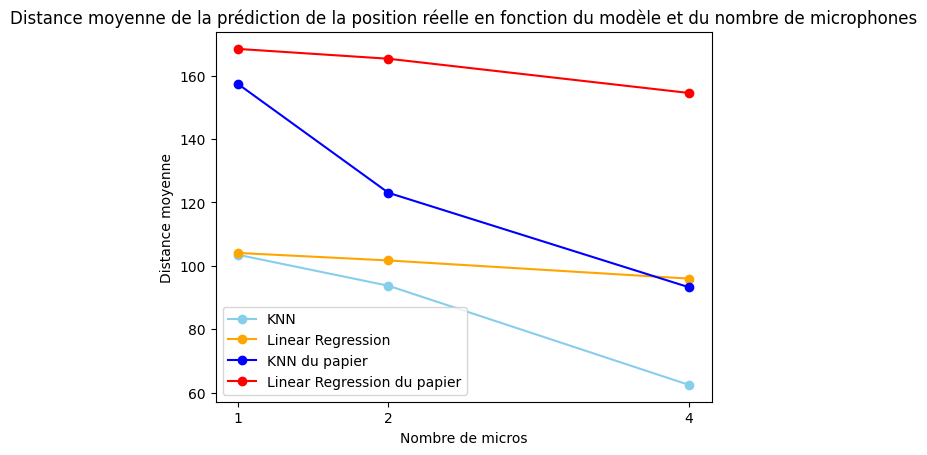

In [20]:
# Plot des résultats de KNN et Linear Regression face aux résultats du livre

# Création des arrays contenant les distances moyennes,
# de nos résultats et de ceux du livre
# Attention: nous ne mettons pas nos résultats pour 3 micros car le livre non plus
knn_avg_dists = [knn_eval_1, knn_eval_2, knn_eval]
lr_avg_dists = [lr_eval_1, lr_eval_2, lr_eval]
knn_book = [157.3, 123.0, 93.2]
lr_book = [168.4, 165.3, 154.5]

# Simple array du nombres de microphones
microphone_counts = [1, 2, 4]

plt.plot(microphone_counts, knn_avg_dists, marker='o', color='skyblue', linestyle='-', label="KNN")
plt.plot(microphone_counts, lr_avg_dists, marker='o', color='orange', linestyle='-', label="Linear Regression")
plt.plot(microphone_counts, knn_book, marker='o', color='blue', linestyle='-', label="KNN du papier")
plt.plot(microphone_counts, lr_book, marker='o', color='red', linestyle='-', label="Linear Regression du papier")
plt.xticks(microphone_counts)
plt.xlabel('Nombre de micros')
plt.ylabel('Distance moyenne')
plt.title('Distance moyenne de la prédiction de la position réelle en fonction du modèle et du nombre de microphones')
plt.legend()
plt.show()

In [27]:
# Implementation CNN avec Tensorflow

# Definition de l'architecture du Convolution Neural Network
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((4, 1), input_shape=(4,)),
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')


In [28]:
# Entrainement du modèle sur 20 epochs (en mettre plus n'améliore pas les performances du CNN comme visible sur le graphe)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=10)


Epoch 1/20


I0000 00:00:1714039832.258275   26201 service.cc:145] XLA service 0x7fc7f0003f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714039832.264228   26201 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-25 10:10:32.479792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-25 10:10:32.780421: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


64/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3926024.0000

I0000 00:00:1714039834.753713   26201 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 3921498.7500 - val_loss: 4063697.0000
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3784323.5000 - val_loss: 4008744.2500
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3821522.0000 - val_loss: 3840998.2500
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3484322.5000 - val_loss: 3518957.2500
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3082096.7500 - val_loss: 3054747.0000
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2828532.5000 - val_loss: 2538027.5000
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2376507.7500 - val_loss: 2094110.0000
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1977263.0000 - val_loss: 1786639.0000
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1701803.6250 - val_loss: 1627574.2500
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1646215.6250 - val_loss: 1553246.3750
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [29]:
# Evaluate the model on the test set
#test_loss = model.evaluate(X_test_scaled, y_test)
#print("Test loss (MSE):", test_loss)

from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate predictions
predictions = model.predict(X_test)

# Calculate Euclidean distance between the predicted and actual positions
errors = np.sqrt(np.sum((y_test - predictions)**2, axis=1))
average_error = np.mean(errors)

print("Average Euclidean distance from actual positions: {:.2f} cm".format(average_error / 10))



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Average Euclidean distance from actual positions: 163.11 cm


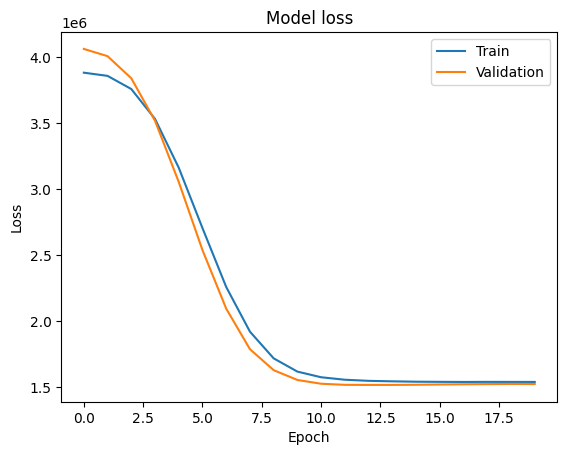

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [4]:
# Implementation VGGish pré-entraîné
# On récupère l'implémentation VGGish du github, qui aura subi quelques modifications pour run
DATASET_PATH = '/home/onyxia/work/hackaton-acoustic/data/LivingRoom_preprocessed_hack/Human1/'
rir_path = os.path.join(DATASET_PATH, "deconvoled_trim.npy")
centroid_path = os.path.join(DATASET_PATH, "centroid.npy")


sys.path.insert(0, "VGGish")
# VGGish pré-entrainé
print("cd VGGish")
print("python train_vggish_localization.py "+rir_path+" " + centroid_path + " --num_channels 4 --pretrained --num_epochs 100 --living")

# l'execution de cette node créera un lien qu'il faudra mettre dans un terminal dans le fichier VGGish


cd VGGish
python train_vggish_localization.py /home/onyxia/work/hackaton-acoustic/data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy /home/onyxia/work/hackaton-acoustic/data/LivingRoom_preprocessed_hack/Human1/centroid.npy --num_channels 4 --pretrained --num_epochs 100 --living


In [5]:
deconv = deconvolved_human1
centroid = centroid_human1

# Presque tout le code présent ici provient du github des scientifiques du papier
# Valeurs par défaut pour le pretrained
precutoff = 92850
vggish_cutoff = 30950

train_indices = np.load("/home/onyxia/work/hackaton-acoustic/indices/train_indices.npy")
test_indices = np.load("/home/onyxia/work/hackaton-acoustic/indices/test_indices.npy")
valid_indices = np.load("/home/onyxia/work/hackaton-acoustic/indices/valid_indices.npy")

test_waves = deconv[test_indices, :]
test_waves =  test_waves[..., :precutoff]
test_waves = torch.Tensor(test_waves).cuda()
test_waves = test_waves[..., :vggish_cutoff]
# uniquement si PAS multi-channel
test_waves = torch.mean(test_waves, dim=1)

train_xy = centroid[train_indices]
test_xy = centroid[test_indices]
valid_xy = centroid[valid_indices]

train_mean = np.mean(train_xy, axis=0)
train_std = np.std(train_xy, axis=0)

test_xy =  (test_xy - train_mean) / (train_std + 1e-8)
test_xy = torch.Tensor(test_xy).cuda()
train_xy =  (train_xy - train_mean) / (train_std + 1e-8)
train_xy = torch.Tensor(train_xy).cuda()
valid_xy = (valid_xy - train_mean) / (train_std + 1e-8)
valid_xy = torch.Tensor(valid_xy).cuda()


# =On passe train_xy en numpy pour norm_val_min et morn_val_range
train_xy_cpu = train_xy.cpu() 
train_xy_numpy = train_xy_cpu.numpy()

# idem
valid_xy_cpu = valid_xy.cpu()
valid_xy_numpy = valid_xy_cpu.numpy()

epsilon = 1e-2
norm_val_min = np.min(np.concatenate((train_xy_numpy, valid_xy_numpy), axis=0))
norm_val_range = np.max(np.concatenate((train_xy_numpy, valid_xy_numpy), axis=0)) - norm_val_min

def postprocess_net_output(output):
    output[:, :2] = norm_val_range * ((torch.tanh(output[:, :2]) * (1 + epsilon)) + 1) / 2 + norm_val_min
    return output

train_std_cuda = torch.Tensor(train_std).cuda()
train_mean_cuda = torch.Tensor(train_mean).cuda()

def unnormalize(xy):
    return xy*(train_std_cuda + 1e-8) + train_mean_cuda

In [9]:
# Node d'évaluation du modèle pré-entraîné
sys.path.insert(0, "VGGish")
from VGGish.models import get_finetune_model

MODEL_PATH = '/home/onyxia/work/hackaton-acoustic/VGGish/model.pt'
if (os.path.exists(MODEL_PATH)):
    file = torch.load(MODEL_PATH)
    # Pour multi-channel, il faut CustomVGGish2(in_channels=4, out_channels=2)
    model = get_finetune_model(pretrained=True, frozen=True, out_channels=2)
    model.state_dict = file['model_state_dict']

    test_errors = np.zeros(test_waves.shape[0], dtype=np.float32)

    for i in range(test_waves.shape[0]):
        with torch.no_grad():
            results = torch.squeeze(postprocess_net_output(model(torch.unsqueeze(test_waves[i, :], axis=0)).view(-1, 1)))
        
        
        test_errors[i] = torch.norm(unnormalize(results[:2]) - unnormalize(test_xy[i, :2])).item()

    print("TEST ERROR")
    print(test_errors)
    
    print("MEAN TEST ERROR:",flush=True)
    print(np.mean(test_errors / 10 ), "cm")
    print("MED TEST ERROR")
    print(np.median(test_errors /10), "cm")
    print("STD TEST ERROR")
    print(np.std(test_errors / 10), "cm")

    np.save(os.path.join('/home/onyxia/work/hackaton-acoustic/VGGish/errors', 'test_errors.npy'), np.array(test_errors, dtype=np.float32))    

TEST ERROR
[2059.7036   2481.7878   1615.8275   1983.3096   1861.4567   1954.1279
 2311.1018   1370.0831    868.5585   1964.9523   2060.9573   1007.6387
 1030.4963   1181.4265   1367.921    1373.263    2159.451    1515.61
 1443.3212   1947.351    1853.6489   2121.0876   3095.4773   1787.378
 1510.2603   1820.0658   1870.5145   1805.2034   2612.8435   1870.8109
  368.4872   2019.905     530.0546   1461.0084   1476.0044   2028.7745
 2040.1122   1494.7845   1017.7717   2523.7336   2267.8167   1472.138
  359.49536   736.70746  1861.1543   1030.1173   2065.6636   2683.97
 1819.068    2327.9277   1466.2649   2208.0325   2369.0398   1459.6116
 1521.7677   1472.4453   1576.8138   1098.711    2409.6365   1356.5585
 1690.6565   1738.9447   2186.737    2077.8418   1232.7205   1524.622
 2334.5286   1036.0206   1788.7449   2592.9902   1835.1338   1019.65546
   46.580345 2096.8098    833.8111   2153.0515   1483.2065   1131.1155
 2347.8167    464.751    2035.7494    677.8007    882.86694  1046.3363
 

In [6]:
precutoff = 92850
vggish_cutoff = 15475

In [7]:
# Implementation VGGish multi-channel
# On récupère l'implémentation VGGish du github, qui aura subi quelques modifications pour run
DATASET_PATH = '/home/onyxia/work/hackaton-acoustic/data/LivingRoom_preprocessed_hack/Human1/'
rir_path = os.path.join(DATASET_PATH, "deconvoled_trim.npy")
centroid_path = os.path.join(DATASET_PATH, "centroid.npy")


sys.path.insert(0, "VGGish")
# VGGish multi-channel
print("cd VGGish")
print("python train_vggish_localization.py "+rir_path+" " + centroid_path + " --num_channels 4 --multi_chan --num_epochs 100 --living")

# l'execution de cette node créera un lien qu'il faudra mettre dans un terminal dans le fichier VGGish


cd VGGish
python train_vggish_localization.py /home/onyxia/work/hackaton-acoustic/data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy /home/onyxia/work/hackaton-acoustic/data/LivingRoom_preprocessed_hack/Human1/centroid.npy --num_channels 4 --multi_chan --num_epochs 100 --living


In [8]:
# Node d'évaluation du modèle multi-channel
sys.path.insert(0, "VGGish")
from VGGish.models import CustomVGGish2

MODEL_PATH = '/home/onyxia/work/hackaton-acoustic/VGGish/model.pt'
if (os.path.exists(MODEL_PATH)):
    file = torch.load(MODEL_PATH)
    # Pour multi-channel, il faut CustomVGGish2(in_channels=4, out_channels=2)
    model = CustomVGGish2(in_channels=4, out_channels=2)
    model.state_dict = file['model_state_dict']

    test_errors = np.zeros(test_waves.shape[0], dtype=np.float32)

    for i in range(test_waves.shape[0]):
        with torch.no_grad():
            results = torch.squeeze(postprocess_net_output(model(torch.unsqueeze(test_waves[i, :], axis=0)).view(-1, 1)))
        
        
        test_errors[i] = torch.norm(unnormalize(results[:2]) - unnormalize(test_xy[i, :2])).item()

    print("TEST ERROR")
    print(test_errors)
    
    print("MEAN TEST ERROR",flush=True)
    print(np.mean(test_errors / 10), "cm")
    print("MED TEST ERROR")
    print(np.median(test_errors / 10), "cm")
    print("STD TEST ERROR")
    print(np.std(test_errors / 10), "cm")

    np.save(os.path.join('/home/onyxia/work/hackaton-acoustic/VGGish/errors', 'test_errors.npy'), np.array(test_errors, dtype=np.float32))    

/opt/mamba/lib/python3.11/site-packages/torch/functional.py:660: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:874.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


RuntimeError: shape '[1, 30950, 194, 64]' is invalid for input of size 12416

### Malgré l'erreur, on a quand même des resultats disponibles sur le terminal une fois la commande du multi-channel terminée:
MEAN TEST ERROR : 35.86 cm

MED TEST ERROR : 35.08 cm

STD TEST ERROR : 22.86 cm

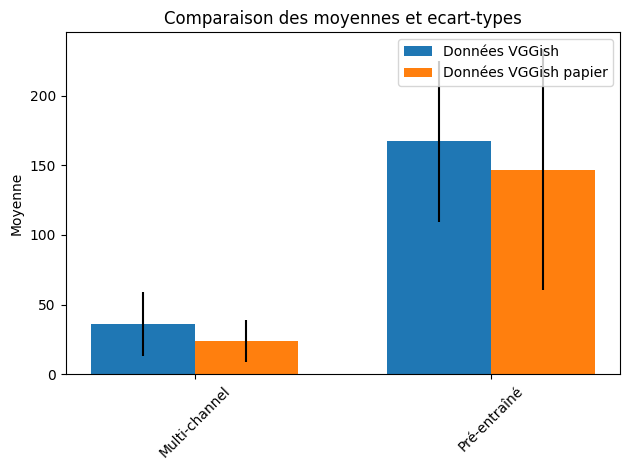

In [14]:
# Plot de nos données face à celles du papier
multi_chan_mean = 35.86
pretrained_mean = 167.37798
multi_chan_std = 22.856067
pretrained_std = 57.87287
paper_pretrained_mean = 147.0
paper_pretrained_std = 86.9
paper_multichannel_mean = 23.6
paper_multichannel_std = 15.0


# Data
categories = ['Multi-channel', 'Pré-entraîné']
means_data = [multi_chan_mean, pretrained_mean]
stds_data = [multi_chan_std, pretrained_std]
means_paper = [paper_multichannel_mean, paper_pretrained_mean]
stds_paper = [paper_multichannel_std, paper_pretrained_std]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_data, width, yerr=stds_data, label='Données VGGish')
rects2 = ax.bar(x + width/2, means_paper, width, yerr=stds_paper, label='Données VGGish papier')

# Add labels, title, and legend
ax.set_ylabel('Moyenne')
ax.set_title('Comparaison des moyennes et ecart-types')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()